<a href="https://colab.research.google.com/github/Arazsh/Sign-Language-Recognizer/blob/main/Copy_of_SignLanguageClassification_ImageAugmentaion_Callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing the required libraries

import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
%matplotlib inline
import matplotlib.pyplot as plt

#Using callbacks to stop training after reaching to a certain accuracy
class myCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end (self, epoch, logs ={}):
        if (logs.get('accuracy')>0.92):
            print("Reached to 92% of training accuracy, training is enough")
            self.model.stop_training = True

callbacks = myCallbacks()

In [3]:
#Download the two 2 CSV files, sign_mnist_test.csv and sign_mnist_train.csv form https://www.kaggle.com/datamunge/sign-language-mnist/home to your machine, 
#and upload them to the notebook using the following botton.
uploaded=files.upload()

Saving sign_mnist_test.csv to sign_mnist_test.csv
Saving sign_mnist_train.csv to sign_mnist_train.csv


unique labels =  [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.] number of unique labels = 24
num_train = 27455 num_test =  7172 image size = (28, 28)


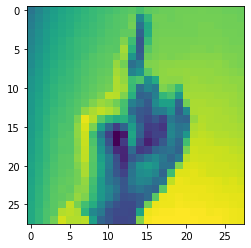

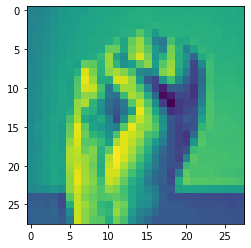

In [17]:
#This function is to read the .CSV files and convert them to train/test images.
#Each line contians 785 comma separated values between 0 and 255
#The first value is the label which is an integer between 0 and 24 (25 classes)
#The 784 pixel values (comma separated values) should be converted to 28*28 images

def get_data(filename):
    with open(filename) as training_file:
      reader = csv.reader(training_file, delimiter=',')    
      imgs = []
      labels = []

      next(reader, None)
        
      for row in reader:
          label = row[0]
          data = row[1:]
          #the size of the images is 28*28
          img = np.array(data).reshape((28, 28))

          imgs.append(img)
          labels.append(label)

      images = np.array(imgs).astype(float)
      labels = np.array(labels).astype(float)
    return images, labels


training_images, training_labels = get_data('sign_mnist_train.csv')
testing_images, testing_labels = get_data('sign_mnist_test.csv')

cls_labels = np.unique(training_labels)
print('unique labels = ', cls_labels, 'number of unique labels =',cls_labels.shape[0])

print('num_train =',training_images.shape[0],'num_test = ',testing_images.shape[0] ,'image size =',training_images.shape[1:])

#Displaying example images from the dataset
plt.imshow(training_images[0].astype(np.uint8))
plt.show()
plt.imshow(training_images[10].astype(np.uint8))
plt.show()


In [10]:
#This part of the code is used to add one more dimension to numpy arrays to convert them to images that can be used by ImageDataGenerator.
#The numpy labels are also converted to categorical to be used by ImageDataGenerator to create the test and train data.

from tensorflow.keras import utils

training_images = np.expand_dims(training_images,axis=3)
testing_images = np.expand_dims(testing_images,axis=3)
training_labels = utils.to_categorical(training_labels, num_classes=25)
testing_labels = utils.to_categorical(testing_labels, num_classes=25)


# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
                                   rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_datagen.fit(training_images)

#Creating train data using flow
train_generator=train_datagen.flow(training_images, training_labels, batch_size=32)

#Normalizing test images 
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen.fit(testing_images)
#Creating test data using flow
validation_generator=validation_datagen.flow(testing_images, testing_labels, batch_size=32)
    
print(training_images.shape)
print(testing_images.shape)
    


(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [14]:
# Defining a model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    #512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    #node 10 won't be assigned 
    tf.keras.layers.Dense(25, activation='softmax')
])
model.summary()
#Compile Model. 
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#Train the Model
history = model.fit_generator(train_generator, epochs=40, 
                              validation_data = validation_generator, verbose = 1, callbacks=[callbacks]
)
model.evaluate(testing_images, testing_labels)
    



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2

[275.09716796875, 0.7052426338195801]

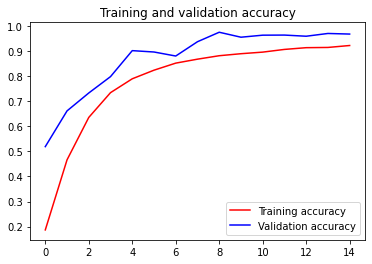

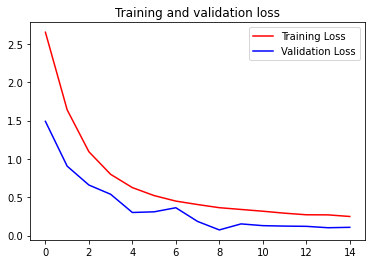

In [15]:
# Plotting accuracy and loss on both training and validation VS epochs

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()